In [1]:
import pandas as pd
import numpy as np
import talib as ta
from sklearn.neighbors import KNeighborsClassifier
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
# Download historical data (replace with your data source if needed)
data = yf.download('AAPL', start='2024-10-01', end='2024-10-03', interval='5m')  # 1-minute interval
data['Close'] = data['Close'].ffill()

# Compute Technical Indicators
def compute_indicators(data, short_window=14, long_window=28):
    data['RSI_short'] = ta.RSI(data['Close'], timeperiod=short_window)
    data['RSI_long'] = ta.RSI(data['Close'], timeperiod=long_window)
    
    data['CCI_short'] = ta.CCI(data['High'], data['Low'], data['Close'], timeperiod=short_window)
    data['CCI_long'] = ta.CCI(data['High'], data['Low'], data['Close'], timeperiod=long_window)
    
    data['ROC_short'] = ta.ROC(data['Close'], timeperiod=short_window)
    data['ROC_long'] = ta.ROC(data['Close'], timeperiod=long_window)
    
    # Normalize volume between 0 and 100
    data['Volume_norm_short'] = (data['Volume'] - data['Volume'].rolling(short_window).min()) / (data['Volume'].rolling(short_window).max() - data['Volume'].rolling(short_window).min()) * 100
    data['Volume_norm_long'] = (data['Volume'] - data['Volume'].rolling(long_window).min()) / (data['Volume'].rolling(long_window).max() - data['Volume'].rolling(long_window).min()) * 100

# Call the function to compute the indicators
compute_indicators(data)

# Filter the data to remove rows with NaN values (from indicator calculations)
data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [3]:
features = ['RSI_short', 'RSI_long', 'CCI_short', 'CCI_long', 'ROC_short', 'ROC_long', 'Volume_norm_short', 'Volume_norm_long']

# Define the target variable (Buy/Sell signal: +1 for Buy, -1 for Sell)
data['Signal'] = np.sign(data['Close'].shift(-1) - data['Close']) # Predicting the next bar's direction (Buy or Sell)

# Prepare the data for kNN
X = data[features].values
y = data['Signal'].values

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train kNN model
k = 10  # Number of nearest neighbors
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Predict the market direction on the test set
predictions = knn.predict(X_test)

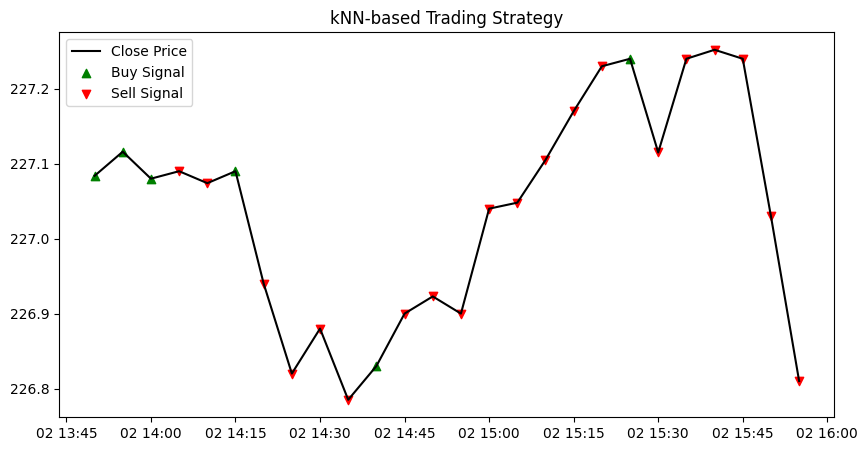

In [4]:
# Get the predictions for the last 10 days


plt.figure(figsize=(10, 5))
plt.plot(data.index[train_size:], data['Close'][train_size:], label='Close Price', color='black')
plt.scatter(data.index[train_size:][predictions > 0], data['Close'][train_size:][predictions > 0], label='Buy Signal', marker='^', color='green')
plt.scatter(data.index[train_size:][predictions < 0], data['Close'][train_size:][predictions < 0], label='Sell Signal', marker='v', color='red')
plt.legend(loc='best')
plt.title('kNN-based Trading Strategy')
plt.show()

In [11]:
# Initialize variables
initial_capital = 100.0  # Starting account balance
total_capital = initial_capital
current_position = 0.0  # Track the current position size (number of assets)
cost_basis = 0.0  # Total amount spent on current positions

# Loop through the DataFrame to set Strategy_Returns based on the signals
for i in range(1, len(data)):
    if data['Signal'].iloc[i] == 1.0:  # Buy signal
        investment = total_capital * 0.2  # 20% of the current capital
        if investment > 0:
            cost_basis += investment  # Update cost basis

            # Update current position
            shares_bought = investment / data['Close'].iloc[i]  # Number of assets bought
            current_position += shares_bought  # Increase position size
            total_capital -= investment  # Deduct investment from total capital
            
            print(f"Buying {shares_bought:.2f} shares at ${data['Close'].iloc[i]:.2f}, Total Capital: ${total_capital:.2f}, Money Spend: ${investment:.2f}")

    elif data['Signal'].iloc[i] == -1.0:  # Sell signal
        if current_position > 0:  # Ensure there is a position to sell
            sale_value = current_position * data['Close'].iloc[i]  # Total value from selling
            profit = sale_value - cost_basis  # Calculate profit/loss from the sale
            
            # Record the trade's profit/loss
            total_capital += sale_value  # Update total capital with the sale value
            print(f"Selling {current_position:.2f} shares at ${data['Close'].iloc[i]:.2f}, Sale Value: ${sale_value:.2f}, Profit: ${profit:.2f}, Total Capital: ${total_capital:.2f} ")
            
            # Reset the position and cost basis
            current_position = 0.0
            cost_basis = 0.0

# After the loop, you can calculate total profit/loss

print(f"\nInitial Capital: ${initial_capital:.2f}")
print(f"Final Capital: ${total_capital:.2f}")
print(f"Total Profit from trades: ${total_capital - initial_capital:.2f}")

Buying 0.09 shares at $225.22, Total Capital: $80.00, Money Spend: $20.00
Buying 0.07 shares at $225.44, Total Capital: $64.00, Money Spend: $16.00
Selling 0.16 shares at $225.64, Sale Value: $36.05, Profit: $0.05, Total Capital: $100.05 
Buying 0.09 shares at $225.29, Total Capital: $80.04, Money Spend: $20.01
Selling 0.09 shares at $225.46, Sale Value: $20.03, Profit: $0.02, Total Capital: $100.07 
Buying 0.09 shares at $224.44, Total Capital: $80.05, Money Spend: $20.01
Selling 0.09 shares at $224.78, Sale Value: $20.04, Profit: $0.03, Total Capital: $100.10 
Buying 0.09 shares at $224.01, Total Capital: $80.08, Money Spend: $20.02
Selling 0.09 shares at $224.02, Sale Value: $20.02, Profit: $0.00, Total Capital: $100.10 
Buying 0.09 shares at $223.93, Total Capital: $80.08, Money Spend: $20.02
Selling 0.09 shares at $224.52, Sale Value: $20.07, Profit: $0.05, Total Capital: $100.15 
Buying 0.09 shares at $224.32, Total Capital: $80.12, Money Spend: $20.03
Selling 0.09 shares at $224